# Лабораторная работа 3. Линейные методы.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_03.ipynb.

<a id='log_reg'></a>
## Логистическая регрессия

В этом пункте мы будем рассматривать бинарную классификацию, где метки классов лежат во множестве $\{-1, 1\}$. 

Задачу обучения регуляризованной логистической регрессии можно записать следующим образом:

$$ \dfrac{1}{N}\sum_{i=1}^N \log(1 + \exp(-\langle w, x_i \rangle y_i)) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Обучение в данном случае сводится к нахождению параметров модели $w$, которое производится с помощью метода градиентного спуска (Gradient Descent, GD). 

Градиентный шаг будет заключаться в обновлении вектора весов по следующей формуле:

$$w := w + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w, x_i \rangle y_i)}\Big) - \eta Cw$$

где $\eta > 0$ — размер шага (learning rate).

В общем случае метод градиентного спуска имеет следующие недостатки:
- попадание в локальные минимумы
- неочевидность критерия останова
- выбор размера шага
- начальная инициализация весов

В этой части лабораторной работы мы предложим вам реализовать метод градиентного спуска, а также рассмотрим некоторые его модификации.



In [3]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline

### Задание

Сгенерируйте выборку из 1000 точек с 20 признаками на которой будете проводить эксперименты. Мы рекомендуем воспользоваться функцией [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) из пакета sklearn. Обратите внимание, что метки классов для данной задачи должны быть из множества {-1, 1} (по умолчанию make_classification возвращает метки из множества {0, 1}).

**(3.5 балла)** Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на ранее сгенерированной выборке. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-6
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость.
- Рассмотрите регуляризованную модель, которая описана выше, а также модель без регуляризатора. Сравните влияет ли наличие регуляризации на скорость сходимости и качество.
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

In [4]:
import sklearn.datasets

x, y = sklearn.datasets.make_classification(1000, 20)
y[y == 0] = -1

In [5]:
def init_weights(size, init_type = 'random'):
    if (init_type == 'random'):
        return np.random.uniform(-1./(2*size), 1./(2*size), size)
    elif (init_type == 'zero'):
        return np.zeros(size)

def grad_descent(x, y, eta, C=0, iters_limit = 10000, w_init = 'random'):
    N = x.shape[0]
    n = x.shape[1]
    all_w_iterations = []
    w = init_weights(n, w_init)
    all_w_iterations.append(w)
    w_old = w
    temp = np.zeros(n)
    for i in range(N):
        temp += x[i]*y[i]*(1-1./(1 + np.exp(-y[i]*x[i].dot(w_old.T))))
    w = w_old + (eta*1./N)*temp - C*eta*w_old
    all_w_iterations.append(w)
    iters_count = 1
    while np.linalg.norm(w-w_old) > 1e-6 and iters_count < iters_limit:
        w_old = w
        temp = np.zeros(n)
        for i in range(N):
            temp += x[i]*y[i]*(1-1./(1 + np.exp(-y[i]*(x[i].dot(w_old.T)))))
        w = w_old + (eta*1./x.shape[0])*temp - C*eta*w_old
        all_w_iterations.append(w)
        iters_count += 1
    return w, iters_count, all_w_iterations
    
def count_functional(x, y, w, C=0):
    N = x.shape[0]
    result = 0
    for i in range(N):
        result += np.log(1 + np.exp(-y[i]*x[i].dot(w.T)))/N
    result += (C/2)*(np.linalg.norm(w))**2
    return result

**Посмотрим, как зависит число итераций от значения параметра "эта", а также посмотрим на значение функционала (начальная инициализация - случайный вектор, координаты которого равномерно распределены на $[-\frac{1}{2n}, \frac{1}{2n}]$.**

In [6]:
w, iters, w_s = grad_descent(x, y, 0.01, C=1)
print('Number of iterations with eta=0.01: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.02, C=1)
print('Number of iterations with eta=0.02: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.05, C=1)
print('Number of iterations with eta=0.05: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.1, C=1)
print('Number of iterations with eta=0.1: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.3, C=1)
print('Number of iterations with eta=0.3: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.5, C=1)
print('Number of iterations with eta=0.5: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.75, C=1)
print('Number of iterations with eta=0.75: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 1, C=1)
print('Number of iterations with eta=1: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

Number of iterations with eta=0.01:  590
Value of functional with this eta:  0.556672212428
Number of iterations with eta=0.02:  324
Value of functional with this eta:  0.556672209692
Number of iterations with eta=0.05:  142
Value of functional with this eta:  0.556672208812
Number of iterations with eta=0.1:  74
Value of functional with this eta:  0.556672208683
Number of iterations with eta=0.3:  25
Value of functional with this eta:  0.556672208659
Number of iterations with eta=0.5:  14
Value of functional with this eta:  0.556672208658
Number of iterations with eta=0.75:  17
Value of functional with this eta:  0.556672208657
Number of iterations with eta=1:  148
Value of functional with this eta:  0.556672208658


Нетрудно видеть, что с увеличением значения параметра "эта" количество итераций метода уменьшается, то есть метод сходится быстрее.

**Расмотрим нерегуляризованную модель и сравним её с регуляризованной по значению минимизируемого функционала.**

In [108]:
w, iters, w_s = grad_descent(x, y, 0.01)
print('Number of iterations with eta=0.01: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = grad_descent(x, y, 0.02)
print('Number of iterations with eta=0.02: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

Number of iterations with eta=0.01:  10000
Value of functional with this eta:  0.171234180255


KeyboardInterrupt: 

Заметим, что сходится метод очень медленно, при этом даёт меньшее значение минимизируемого функционала. Значит, присутствие регуляризатора ускоряет сходимость метода, но при этом значение функционала ухудшается.

**Построим график зависимости качества функционала от номера итерации.**

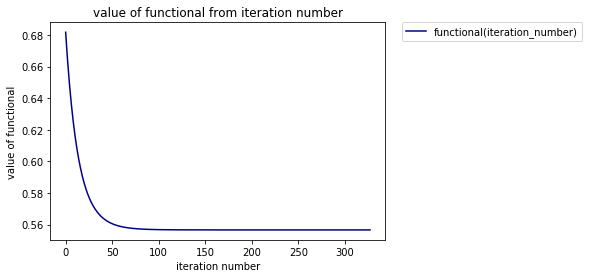

In [7]:
w, iters, w_s = grad_descent(x, y, 0.02, C=1)
funcs = []
for i in w_s:
    funcs.append(count_functional(x, y, i, C=1))
plt.plot(np.arange(iters+1), funcs, color = 'darkblue', label = 'functional(iteration_number)')
plt.title('value of functional from iteration number')
plt.xlabel('iteration number')
plt.ylabel('value of functional')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

На графике значение функционала убывает с увеличением количества итераций, как и ожидалось.

**Рассмотрим теперь метод, где первоначально вектор весов инициализируем нулевыми значениями и посмотрим, как будут результаты отличаться от метода со случайной первоначальной инициализацией.**

In [8]:
w, iters, w_s = grad_descent(x, y, 0.01, C=1, w_init='zero')
print('Number of iterations with eta=0.01: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.02, C=1, w_init='zero')
print('Number of iterations with eta=0.02: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.05, C=1, w_init='zero')
print('Number of iterations with eta=0.05: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.1, C=1, w_init='zero')
print('Number of iterations with eta=0.1: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

w, iters, w_s = grad_descent(x, y, 0.3, C=1, w_init='zero')
print('Number of iterations with eta=0.3: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w, C=1))

Number of iterations with eta=0.01:  564
Value of functional with this eta:  0.55667221199
Number of iterations with eta=0.02:  304
Value of functional with this eta:  0.556672209483
Number of iterations with eta=0.05:  132
Value of functional with this eta:  0.556672208779
Number of iterations with eta=0.1:  69
Value of functional with this eta:  0.556672208681
Number of iterations with eta=0.3:  22
Value of functional with this eta:  0.556672208659


В результате метод с нулевой начальной реализацией даёт примерно то же значение функционала, что и метод со случайной начальной инициализацией, а количество итераций меньше, но совсем ненамного (где-то пара-тройка процентов от общего числа итераций, а то и меньше).

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1 балл)** Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

- Посмотрите как влияет размер шага на сходимость
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации 

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

**Будем реализовывать метод без регуляризации, по умолчанию первоначальная генерация весов случайна, а коэффициент темпа забывания равен 0.5.**

In [9]:
def L(x, y, w):
    return np.log(1 + np.exp(-y*x.dot(w.T)))

def nabla_L(x, y, w):
    return x*y*(1-1./(1 + np.exp(-y*(x.dot(w.T)))))
    
def stoch_grad_descent(x, y, h = 0.5, lambda_ = 0.5, w_init = 'random'):
    N = x.shape[0]
    n = x.shape[1]
    all_w_iterations = []
    w = init_weights(n, w_init)
    all_w_iterations.append(w)
    Q = count_functional(x, y, w)
    w_old = w
    Q_old = Q
    index = np.random.randint(0, N, 1)
    eps = L(x[index[0]], y[index[0]], w_old)
    w = w_old + h*nabla_L(x[index[0]], y[index[0]], w_old)
    all_w_iterations.append(w)
    Q = lambda_*eps + (1-lambda_)*Q_old
    iters_count = 1
    while np.linalg.norm(w-w_old) > 1e-6 and np.absolute(Q-Q_old) > 1e-6:
        w_old = w
        Q_old = Q
        index = np.random.randint(0, N, 1)
        eps = L(x[index[0]], y[index[0]], w_old)
        w = w_old + h*nabla_L(x[index[0]], y[index[0]], w_old)
        all_w_iterations.append(w)
        Q = lambda_*eps + (1-lambda_)*Q_old
        iters_count += 1
    return w, iters_count, all_w_iterations

**Посмотрим на количество итераций и значение функционала для построенного метода.**

In [10]:
w, iters, w_s = stoch_grad_descent(x, y, 0.01)
print('Number of iterations with eta=0.01: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = stoch_grad_descent(x, y, 0.02)
print('Number of iterations with eta=0.02: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = stoch_grad_descent(x, y, 0.05)
print('Number of iterations with eta=0.05: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = stoch_grad_descent(x, y, 0.1)
print('Number of iterations with eta=0.1: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = stoch_grad_descent(x, y, 0.3)
print('Number of iterations with eta=0.3: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = stoch_grad_descent(x, y, 0.5)
print('Number of iterations with eta=0.5: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = stoch_grad_descent(x, y, 0.75)
print('Number of iterations with eta=0.75: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

Number of iterations with eta=0.01:  5733
Value of functional with this eta:  0.262044763722
Number of iterations with eta=0.02:  1352
Value of functional with this eta:  0.268669954373
Number of iterations with eta=0.05:  1595
Value of functional with this eta:  0.268200913807
Number of iterations with eta=0.1:  614
Value of functional with this eta:  0.338200585014
Number of iterations with eta=0.3:  81
Value of functional with this eta:  0.485277292197
Number of iterations with eta=0.5:  35
Value of functional with this eta:  0.504220209538
Number of iterations with eta=0.75:  43
Value of functional with this eta:  1.40702805712


Увеличение шага обучения уменьшает количество итераций, но при этом значение минимизируемого функционала может пострадать.

**Построим график зависимости качества функционала от номера итерации.**

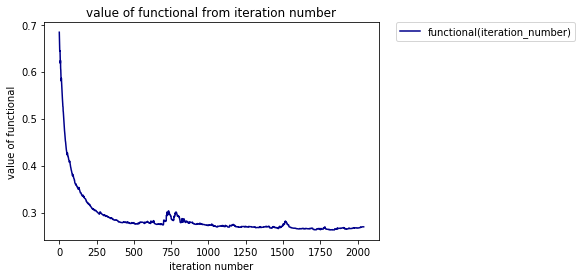

In [11]:
w, iters, w_s = stoch_grad_descent(x, y, 0.02)
funcs = []
for i in w_s:
    funcs.append(count_functional(x, y, i))
plt.plot(np.arange(iters+1), funcs, color = 'darkblue', label = 'functional(iteration_number)')
plt.title('value of functional from iteration number')
plt.xlabel('iteration number')
plt.ylabel('value of functional')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Как и ожидалось, график - убывающая функция, что говорит о том, что минимизируемый функционал уменьшается на каждой следующей итерации.

**Метод стохастического градиентного спуска лучше минимизиреут функционал, чем регуляризованный нестохастический градиентный спуск, но по результатам нерегуляризованного нестохастического градиентного спуска (хоть тот и плохо сходится) можно говорить, что функционал минимизируется ненамного лучше стохастическим методом, чем нестохастическим. Количество итераций, очевидно, куда больше у стохастического метода, но это большое количество выполняется во много раз быстрее, чем большое количество итераций нестохастического метода. В плане реализации второй метод ненамного сложнее первого.**

**(0.5 балла)** Добавьте в выборку случайный шум следующим способом:
 1. Выберите случайно 3% объектов из сгенерированной ранее выборки.
 2. Сдвиньте эти объекты на $\mathcal{N}(0; 3 * scale)$, где $scale$ —  масштаб, который был использован при генерации объектов (параметр $scale$ в make_classification).
 3. Инвертируйте классы выбранных объектов.
 
Для GD и SGD сравните скорость сходимости и значение функции потерь до и после добавления шума. 

In [120]:
indices = np.random.randint(0, x.shape[0], int(x.shape[0]*0.03))
x_ = np.empty_like(x)
x_[:] = x
y_ = np.empty_like(y)
y_[:] = y
x_[indices] += np.random.normal(0, 3., 1)[0]
y_[indices] = y_[indices]*-1

**GD:**

In [124]:
w, iters, w_s = grad_descent(x_, y_, 0.01, C=1)
print('Number of iterations with eta=0.01: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w, C=1))

w, iters, w_s = grad_descent(x_, y_, 0.02, C=1)
print('Number of iterations with eta=0.02: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w, C=1))

w, iters, w_s = grad_descent(x_, y_, 0.05, C=1)
print('Number of iterations with eta=0.05: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w, C=1))

w, iters, w_s = grad_descent(x_, y_, 0.1, C=1)
print('Number of iterations with eta=0.1: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w, C=1))

w, iters, w_s = grad_descent(x_, y_, 0.3, C=1)
print('Number of iterations with eta=0.3: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w, C=1))

Number of iterations with eta=0.01:  644
Value of functional with this eta:  0.610946925338
Number of iterations with eta=0.02:  340
Value of functional with this eta:  0.61094692221
Number of iterations with eta=0.05:  149
Value of functional with this eta:  0.61094692147
Number of iterations with eta=0.1:  76
Value of functional with this eta:  0.610946921367
Number of iterations with eta=0.3:  27
Value of functional with this eta:  0.61094692134


**Значение функционала немного увеличилось, количество итераций уменьшилось, но ненамного.**

**GCD:**

In [125]:
w, iters, w_s = stoch_grad_descent(x_, y_, 0.01)
print('Number of iterations with eta=0.01: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w))

w, iters, w_s = stoch_grad_descent(x_, y_, 0.02)
print('Number of iterations with eta=0.02: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w))

w, iters, w_s = stoch_grad_descent(x_, y_, 0.05)
print('Number of iterations with eta=0.05: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w))

w, iters, w_s = stoch_grad_descent(x_, y_, 0.1)
print('Number of iterations with eta=0.1: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w))

w, iters, w_s = stoch_grad_descent(x_, y_, 0.3)
print('Number of iterations with eta=0.3: ', iters)
print('Value of functional with this eta: ', count_functional(x_, y_, w))

Number of iterations with eta=0.01:  13372
Value of functional with this eta:  0.286926394516
Number of iterations with eta=0.02:  22965
Value of functional with this eta:  0.270921075147
Number of iterations with eta=0.05:  21545
Value of functional with this eta:  0.308937719891
Number of iterations with eta=0.1:  1317
Value of functional with this eta:  0.341101006595
Number of iterations with eta=0.3:  118
Value of functional with this eta:  0.444700109129


**В случае этого метода шум значительно увеличил для маленького шага обучения количество итераций, значение функционала увеличилось.**

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta_i)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

### Задание

Реализуйте метод оптимизации *Momentum* **(0.5 балла)** и один из *Adagrad*/*Adadelta* **(1 балл)**. 
- Сравните с классическим sgd. 
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.
- Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

**Momentum:**

In [135]:
def momentum_stoch_grad_descent(x, y, h = 0.5, lambda_ = 0.5, w_init = 'random', gamma = 0.9):
    N = x.shape[0]
    n = x.shape[1]
    all_w_iterations = []
    w = init_weights(n, w_init)
    all_w_iterations.append(w)
    Q = count_functional(x, y, w)
    nu = np.zeros(n)
    w_old = w
    Q_old = Q
    nu_old = nu
    index = np.random.randint(0, N, 1)
    eps = L(x[index[0]], y[index[0]], w_old)
    nu = -gamma*nu_old + h*nabla_L(x[index[0]], y[index[0]], w_old)
    w = w_old + nu
    all_w_iterations.append(w)
    Q = lambda_*eps + (1-lambda_)*Q_old
    iters_count = 1
    while np.linalg.norm(w-w_old) > 1e-6 and np.absolute(Q-Q_old) > 1e-6:
        w_old = w
        Q_old = Q
        nu_old = nu
        index = np.random.randint(0, N, 1)
        eps = L(x[index[0]], y[index[0]], w_old)
        nu = -gamma*nu_old + h*nabla_L(x[index[0]], y[index[0]], w_old)
        w = w_old + nu
        all_w_iterations.append(w)
        Q = lambda_*eps + (1-lambda_)*Q_old
        iters_count += 1
    return w, iters_count, all_w_iterations

In [136]:
w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.01)
print('Number of iterations with eta=0.01: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.02)
print('Number of iterations with eta=0.02: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.05)
print('Number of iterations with eta=0.05: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.1)
print('Number of iterations with eta=0.1: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.3)
print('Number of iterations with eta=0.3: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.5)
print('Number of iterations with eta=0.5: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.75)
print('Number of iterations with eta=0.75: ', iters)
print('Value of functional with this eta: ', count_functional(x, y, w))

Number of iterations with eta=0.01:  22717
Value of functional with this eta:  0.17129529269
Number of iterations with eta=0.02:  5233
Value of functional with this eta:  0.176716287624
Number of iterations with eta=0.05:  12686
Value of functional with this eta:  0.173794034658
Number of iterations with eta=0.1:  9923
Value of functional with this eta:  0.184135883514
Number of iterations with eta=0.3:  786
Value of functional with this eta:  0.224359788758
Number of iterations with eta=0.5:  9974
Value of functional with this eta:  0.331722896479
Number of iterations with eta=0.75:  3553
Value of functional with this eta:  0.398891578264


Результаты относительно sgd ненамного лучше, в некоторых случаях количество итераций становится очень большим.

In [138]:
w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.02, gamma=0.7)
print('Number of iterations with gamma=0.7: ', iters)
print('Value of functional with this gamma: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.02, gamma=0.5)
print('Number of iterations with gamma=0.5: ', iters)
print('Value of functional with this gamma: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.02, gamma=0.4)
print('Number of iterations with gamma=0.4: ', iters)
print('Value of functional with this gamma: ', count_functional(x, y, w))

w, iters, w_s = momentum_stoch_grad_descent(x, y, 0.02, gamma=0.1)
print('Number of iterations with gamma=0.1: ', iters)
print('Value of functional with this gamma: ', count_functional(x, y, w))

Number of iterations with gamma=0.7:  12566
Value of functional with this gamma:  0.174691148394
Number of iterations with gamma=0.5:  63526
Value of functional with this gamma:  0.173408895014
Number of iterations with gamma=0.4:  74358
Value of functional with this gamma:  0.17448178767
Number of iterations with gamma=0.1:  43098
Value of functional with this gamma:  0.173530884898


Судя по результатам, хоть они и зависят от случая, с уменьшением гамма число итераций увеличивается.

### Многоклассовая классификация

Модель логистической регрессии можно обобщить для случая многоклассовой классификации. Метка класса теперь лежит во множестве $\{1, 2, ..., K\}$. Параметры модели $w$ в этом случае являются матрицей размерности $K \times M$, где $M$ − количество признаков. Обучение модели логистической регрессии в многоклассовом случае будет выглядеть следующим образом:

$$ -\dfrac{1}{N}\sum_{i=1}^N \sum_{k=1}^K [y_i = k] \log\Big(\frac{\exp(\langle w_k, x_i \rangle)}{\sum_{s=1}^K \exp(\langle w_s, x_i \rangle))}\Big) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Здесь $w_k$ обозначает $k$-ую строку матрицы $w$.

Обучать эту модель также можно с помощью градиентного спуска.

Кроме того существует другой, более универсальный способ решать задачу многоклассовой классификации. Для этого нужно обучить несколько бинарных моделей классификации, после чего на основании предсказаний по этим моделям вынести окончательный вердикт о принадлежности объекта одному из $K$ классов. Существует две популярные стратегии использования бинарных классификаторов для задачи многоклассовой классификации:
 - OvR (One-vs-Rest, One-vs-All) − стратегия, при которой каждый из $K$ классификаторов обучается отделять объекты одного класса от объектов всех остальных классов. В качестве предсказания используется тот класс, классификатор которого предсказал наибольшую вероятность среди всех.
 - OvO (One-vs-One) − стратегия, при которой каждый из $\frac{K(K-1)}{2}$ классификаторов учится разделять объекты пары классов, игнорируя объекты всех остальных классов. На этапе предсказания класс обычно выбирается путем голосования по вердиктам каждого из классификаторов.


### Задание

**(0.5 балла)** Покажите, что функция потерь для многоклассовой классификации сводится к [функции потерь для бинарной классификации](#log_reg) при $K=2$.
 

$ -\dfrac{1}{N}\sum_{i=1}^N \sum_{k=1}^2 [y_i = k] \log\Big(\frac{\exp(\langle w_k, x_i \rangle)}{\sum_{s=1}^2 \exp(\langle w_s, x_i \rangle))}\Big) = \dfrac{1}{N}\sum_{i=1}^N \sum_{k=1}^2 [y_i = k] \log\Big(\frac{\sum_{s=1}^2 \exp(\langle w_s, x_i \rangle))}{\exp(\langle w_k, x_i \rangle)}\Big) = \dfrac{1}{N}\Big(\sum_{i=1}^N [y_i = 1] \log\Big(\frac{\sum_{s=1}^2 \exp(\langle w_s, x_i \rangle))}{\exp(\langle w_1, x_i \rangle)}\Big) + \sum_{i=1}^N [y_i = 2] \log\Big(\frac{\sum_{s=1}^2 \exp(\langle w_s, x_i \rangle))}{\exp(\langle w_2, x_i \rangle)}\Big)\Big) = \dfrac{1}{N}\Big(\sum_{i=1}^N [y_i = 1] \log\Big(1+\exp(\langle w_2-w_1, x_i \rangle)\Big) + \sum_{i=1}^N [y_i = 2] \log\Big(1+\exp(\langle w_1-w_2, x_i \rangle)\Big) = [w = w_1-w_2] = \dfrac{1}{N}\Big(\sum_{i=1}^N [y_i = 1] \log\Big(1+\exp(-\langle w, x_i \rangle)\Big) + \sum_{i=1}^N [y_i = 2] \log\Big(1+\exp(\langle w, x_i \rangle)\Big) = [2 := -1] = \dfrac{1}{N}\Big(\sum_{i=1}^N [y_i = 1] \log\Big(1+\exp(-\langle w, x_i \rangle)\Big) + \sum_{i=1}^N [y_i = -1] \log\Big(1+\exp(\langle w, x_i \rangle)\Big) = [\langle \rangle \times y_i^2] = \dfrac{1}{N}\Big(\sum_{i=1}^N [y_i = 1] \log\Big(1+\exp(-y_i\langle w, x_i \rangle y_i)\Big) + \sum_{i=1}^N [y_i = -1] \log\Big(1+\exp(y_i\langle w, x_i \rangle y_i)\Big) = \sum_{i=1}^N \log\Big(1+\exp(-\langle w, x_i \rangle y_i)\Big)$, что и требовалось показать.


**(1 балл)** 
Сгенерируйте несколько выборок точек с 2 признаками и 3 классами (по 100 объектов каждого класса) на которых будете проводить эксперименты. Для этого можно воспользоваться функцией [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) из пакета sklearn.

Обучите [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета sklearn тремя различными способами:
 - в режиме multinomial, оптимизирующем многоклассовую функцию потерь
 - в режиме OvR
 - в режиме OvO
 
Первые два способа реализованы в самом классе LogisticRegression, в то время как для решения задачи третьим методом в sklearn реализован класс [OneVsOneClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) (класс для OvR схемы [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html), конечно, также присутствует в пакете).
 
 
 Проделайте следующие шаги для каждой стратегии и прокомментируйте полученные результаты:
 - Изобразите точки выборки, а также разделяющие прямые (их должно быть по 3 для каждой из стратегий). Проведите эксперимент на всех сгенерированных выборках.
 - Какие особенности, преимущества и недостатки с точки зрения построения разделяющих плоскостей, качества разделения классов и вычислительной эффективности характерны для каждого метода?
 - Для каждой из стратегий приведите примеры ситуаций, когда стоит выбирать ее для решения задачи многоклассовой классификации.


## Линейная регрессия

![](http://66.147.244.197/~globerov/introspectivemode/wp-content/uploads/2012/08/regression-265x300.jpeg)

Метод градиентного спуска позволяет оптимизировать произвольные функции. Например, рассмотрим задачу линейной регрессии, где $y \in \mathbb{R}$, а алгоритм будет иметь вид $a(x) = \langle w, x\rangle$. В случае метода наименьших квадратов оптимизируемый функционал можно записать следующим образом:

$$ \sum_{i=1}^N (\langle w, x_i \rangle - y_i) ^ 2 \to \min_w$$

Эта задача интересна тем, что для нее можно выписать аналитическое решение. Попробуем сравнить эти подходы.

### Задание

Сгенерируйте выборку из 600 точек с двумя признаками для задачи регрессии, воспользовавшись функцией [make_regression](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression). 

**(0.5 балла)** Выпишите как выглядит точное решение задачи линейной регрессии. Решите задачу регрессии с помощью этого подхода без использования и с использованием регуляризации. Есть ли недостатки у такого подхода к решению задачи?

**(0.5 балла)** Примените метод стохастического градиентного спуска реализованный ранее. Сильно ли отличается полученный вектор параметров по сравнению с точным решением? 

К сожалению, линейная регрессия позволяет хорошо восстанавливать *линейные* зависимости, однако в общем случае хуже работает с более сложными данными. Это хорошо можно увидеть на следующем примере.

Пусть исходная зависимость имеет вид $y = x \cdot sin(x)$. Сгенерируем соответствующие точки:

In [2]:
from sklearn.cross_validation import train_test_split

In [3]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

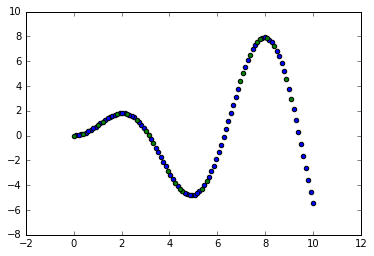

In [4]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

Если теперь к полученным данным применить модель линейной регрессии, то получим следующее решение:

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

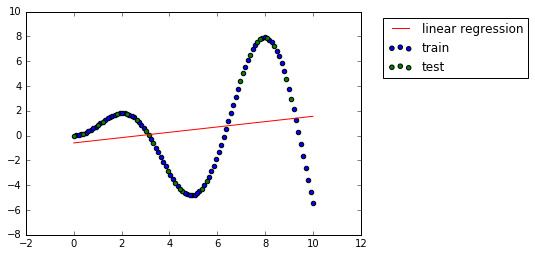

In [7]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Качество модели регрессии можно оценивать с помощью некоторых метрик, например $MSE = \sum_{i=1}^l(a(x_i) - y_i)^2$ и в данном случае оно равно:

In [8]:
from sklearn.metrics import mean_squared_error

In [9]:
mean_squared_error(y_test, lr.predict(X_test[:, np.newaxis])) 

14.759977502823233

Построенное решение совсем отдаленно напоминает исходную зависимость. Одним из способов улучшить результат является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2, \dots$

### Задание

**(0.5 балла)** Воспользуйтесь классом [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) и добавьте к данным зависимости $y = x \cdot sin(x)$ различные полиномы.

 - рассмотрите как степень полинома (от 1 до 20) влияет на качество
 - изобразите на графике предсказание аналогично линейной регрессии
 - сравните этот подход с функцией [polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html)

В чем могут быть недостатки такого подхода?

## Линейный SVM

Вернемся к задаче бинарной классификации. Будем обозначать обучающую выборку $\{(x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

SVM обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям, называются _опорными_.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели. Этот гиперпараметр отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соответствующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального гиперпараметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

Особенность этого метода в том, что он имеет решение, которое может быть найдено используя квадратичное программирование. В этом задании мы не будем сводить данную задачу к задаче квадратичного программирования, а воспользуемся готовой реализацией из библиотеки sklearn.

### Особенности реализации

Обратите внимание, что в библиотеке sklearn можно найти 2 реализации линейного SVM: [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) и [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с ядровой функцией *linear*. Эти реализации имеют различие в библиотеках, на которых основаны: в первом случае используется библиотека *liblinear*, во втором — *libsvm*. Каждая из библиотек имеет свои плюсы, поэтому перед применением стоит определиться какая из реализаций подходит больше. Обратите внимание, что это различие есть только для линейного SVM.

В данном задании рекомендуем использовать класс [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с параметром *kernel='linear'*.

### Задание

Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно-разделимыми классами
- с хорошо разделимыми классами, но не линейно
- с плохо разделимыми классами по имеющимся признакам
    
Для генерации случайной выборки можно воспользоваться функциями, которые находятся в пакете [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). Для того чтобы выборки не менялись при перезапуске ноутбука, фиксируйте параметр *random_state*.

**(1 балл)** Протестируйте линейный SVM  на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

**(1 балл)** Как зависит число опорных векторов от параметра $C$ для различных выборок?

#### Явное преобразование признаков

Как и в случае с линейной регрессией, когда оптимальная разделяющая гиперплоскость не является линейной, данная модель является очень грубым решением. Линейная неразделимость объектов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, аналогичное добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

### Задание

**(1 балл)** На тех же данных используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

## Двойственный переход и Ядровой SVM

![](http://i.imgur.com/bJAzRCt.png)

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](http://www.machinelearning.ru/wiki/images/2/25/SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 


В этом задании используйте класс $sklearn.svm.SVC$, меняя тип ядра. 

### Задание

**(1.5 балла)** Протестируйте на предыдущих двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
- линейная: $k(x, x') = x^Tx'$
- полиномиальная: $k(x, x') = (x^Tx' + 1)^d$ с различными степенями $d = 2,3,\dots$
- Гауссовская-RBF: $k(x, x') = \exp(-\sigma\|x - x'\|^2)$

Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $d$?
 - Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\sigma$? Поварьируйте параметры $C$ и $\sigma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

## Выводы

**(1 балл)** В этой работе вы рассмотрели некоторые линейные модели машинного обучения, а также способы их обучения. Ответьте на следующие вопросы:

 - Какие есть достоинства у рассмотренных моделей? Поясните свой ответ для каждой модели.
 - Каким общим недостатком обладают данные модели? Какие есть способы его устранения? В чем может заключаться сложность использования этого подхода?
 - В чем заключаются различия с точки зрения обучения алгоритмов? Какие есть достоинства и недостатки у рассмотренных методов обучения?
 - Предположите в каком случае каждый из алгоритмов будет работать лучше: при большом/небольшом количестве данных? Поясните почему. 

**Достоинства gd:**
- быстр относительно методов второго порядка.
- прост в реализации.
- детерминирован, что упрощает проверку работы.

**Достоинства sgd:**
- быстр относительно gd.
- для его разработано несколько улучшений.
- прост в реализации.
- подходит для задач с большими данными
- рандомизирован, и его можно запускать несколько раз в надежде получить лучший результат.

**Недостатки:**
- сильно переобучаются.
- можут не сойтись или разойтись
- застревание в локальных экстремумах

Способы: регуляризация, изменение градиентного шага.

sgd удобно применять, если данных много потому что gd будет очень долго в этом случае выполнять одну итерацию, а за это время sgd выполнит их много-много и, скорее всего, эти неколько итераций в сумме лучше оптимизируют функционал, чем одна долгая итерация. Если данных мало, то итерация gd относительно итерации sgd будет выполняться не так долго, а, следовательно, потеря во времени небольшая, зато в оптимизации можно преуспеть.